                    Stable Unit Contract Simulation

    We use two GBMs (Geometric Brownian Motion) as input to a mock Stable Unit contract as a means of estimating the likelyhood of contract outcomes.

    Install and import python libraries.

In [5]:
!pip install numpy
!pip install pandas
!pip install matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import math
import pandas as pd
;

''

    Build two class objects for simulation: 1) A Parameters object which will hold simulation specific parameters and 2) A State object which will hold the current and historical outcomes from a single trial.

In [16]:
class Params:
    """Params hold a set of hyper parameters relevant to a simulation experiment

    Attributes:
        total_steps (int): The total number of steps per trial.
        btc_price_drift (float): BTC Monte Carlo GBM price drift.
        btc_price_volatility (float): BTC Monte Carlo GBM price volatility.
        su_price_drift (float): SU Monte Carlo GBM price drift.
        su_price_volatility (float): SU Monte Carlo std price volatility.
        initial_reserve_ratio (float): The ratio initial between Bitcoin and
            Stable units.
        initial_btc_reserve (float): Initial Bitcoin reserve size.
        initial_btc_price (float): Initial Bitcoin price per unit.
        lowest_ask (float): The contract spread above 1 dollar.
        highest_bid (float): The contract spread bellow 1 dollar.
    """
    def __init__(self):
        self.total_steps = FLAGS_total_steps
        self.total_trials = FLAGS_total_trials
        self.delta_t = FLAGS_delta_t
        self.btc_price_drift = FLAGS_btc_price_drift
        self.btc_price_volatility = FLAGS_btc_price_volatility
        self.su_price_drift = FLAGS_su_price_drift
        self.su_price_volatility = FLAGS_su_price_volatility
        self.initial_reserve_ratio = FLAGS_initial_reserve_ratio
        self.initial_btc_reserve  = FLAGS_initial_btc_reserve
        self.initial_btc_price  = FLAGS_initial_btc_price
        self.lowest_ask = FLAGS_lowest_ask
        self.highest_bid = FLAGS_highest_bid
        self.print_step = FLAGS_print_step

    def __str__(self):
        return (' total steps: ' + "%0.2f" % self.total_steps + '\n' + \
                ' total trials: ' + "%0.2f" % self.total_trials + '\n' + \
    ' delta t: ' + "%0.4f" % self.delta_t + '\n' + \
    ' btc price drift: ' + "%0.4f" % self.btc_price_drift + '\n' + \
    ' btc price volatility: ' + "%0.4f" % self.btc_price_volatility + '\n' + \
    ' su price drift: ' + "%0.4f" % self.su_price_drift + '\n' + \
    ' su price volatility: ' + "%0.4f" % self.su_price_volatility + '\n' + \
    ' initial reserve ratio: '+"%0.4f" % self.initial_reserve_ratio + '\n' + \
    ' initial btc reserve: ' + "%0.4f" % self.initial_btc_reserve + '\n' + \
    ' initial btc price: ' + "%0.4f" % self.initial_btc_price + '\n' + \
    ' lowest ask: ' + "%0.3f" % self.lowest_ask + '\n' + \
    ' highest bid: ' + "%0.3f" % self.highest_bid + '\n' + \
    ' print step: ' + str(self.print_step))


class State:
    """State holds the current and historical values associated with a trial.

    Attributes:
        steps (list[int]): Step number index.
        time_days (list[int]): Days since trial start. 
        su_price (list[int]): Days since trial start. 
        btc_reserve (list[float]): Total BTC in reserve at each step.
        btc_prices (list[float]): USD per unit BTC per step.
        btc_reserve_value (list[float]): US dollar value of BTC reserve.
        reserve_ratio (list[float]): BTC reserve value over SU.
        su_cumulative_demand (list[float]): Cumulative density of Stable unit
            demand at each step.
        su_circulation (list[float]): Total SU in circulation per step.
    """
    def __init__(self, params):
        """ Args:
                params (Class): object carrying hyperparams for experiment.
        """
        self.steps = [0]
        self.time_days = [0]
        self.su_price = [1.0]
        self.btc_reserve = [params.initial_btc_reserve]
        self.btc_prices =  [params.initial_btc_price]
        self.btc_reserve_value = \
            [params.initial_btc_reserve * params.initial_btc_price]
        self.reserve_ratio = [params.initial_reserve_ratio]
        self.su_cumulative_demand = [0.0]
        self.su_circulation = [params.initial_btc_reserve * \
                params.initial_btc_price * 1 / params.initial_reserve_ratio]

    def __str__(self):
        return 'step ' + "%0.0f" % self.steps[-1] +\
               ' time_days ' + "%0.0f" % self.time_days[-1] +\
               ' su_price ' + "%0.2f" % self.su_price[-1] + \
               ' su_total ' + "%0.2f" % self.su_circulation[-1] + \
               ' btc_total ' + "%0.4f" % self.btc_reserve[-1] + \
               ' btc_price ' + "%0.4f" % self.btc_prices[-1] + \
               ' btc_value ' + "%0.4f" % self.btc_reserve_value[-1] + \
               ' reserve_ratio ' + "%0.4f" % self.reserve_ratio[-1]


    Build plotting functions for realizing the individual outcomes from a set of trials.

In [44]:
def plot_bitcoin_price(results):
    """ Plots the Bitcoin price trajectory from each trial..
        Args:
            results (list(Class)): List of state objects from each trial.
    """
    f, (ax1, ax2) = plt.subplots(1, 2)
    final_btc_price = []
    for state in results:
        if len(results) == 1:
            final_btc_price.extend(state.btc_prices)
        else:
            final_btc_price.append(state.btc_prices[-1])
        ax1.plot(state.time_days, state.btc_prices)
    final_btc_price = np.asarray(final_btc_price)

    ax1.set_title('Bitcoin Price (BTC/USD)')
    ax1.set_xlabel('time (days)', fontsize=14)
    ax1.set_ylabel('price (USD)', fontsize=14)

    
    n, bins, patches = ax2.hist(final_btc_price, bins=int(math.sqrt(len(final_btc_price))), facecolor='green', alpha=0.5, orientation='horizontal')
    ax2.axhline(final_btc_price.mean(), color='r', linestyle='dashed', label='mean=' +  "%.2f" % final_btc_price.mean(), linewidth=2)
    ax2.axhline(np.median(final_btc_price), color='b', linestyle='dashed', label='median=' +  "%.2f" % np.median(final_btc_price), linewidth=2)
    ax2.set_xlabel('N Outcomes (/' + str(len(final_btc_price)) +')', fontsize=14)
    ax2.get_yaxis().set_visible(False)
    ax2.legend()

    plt.show()
    
def plot_su_price(results):
    """ Plots the Contract Reserve Ratio trajectory from each trial.
        Args:
            results (list(Class)): List of state objects from each trial.
    """
    f, (ax1, ax2) = plt.subplots(1, 2)
    final_su_price = []
    for state in results:
        if len(results) == 1:
            final_su_price.extend(state.su_price)
        else:
            final_su_price.append(state.su_price[-1])
        ax1.plot(state.time_days, state.su_price)
    final_su_price = np.asarray(final_su_price)

    ax1.set_title('SU Price (USD)')
    ax1.set_xlabel('time (days)', fontsize=14)
    ax1.set_ylabel('SU Price (%)', fontsize=14)
    ax1.set_ylim(0.8, 1.2)  

    n, bins, patches = ax2.hist(final_su_price, bins=int(math.sqrt(len(final_su_price))), facecolor='green', alpha=0.5, orientation='horizontal')
    ax2.axhline(final_su_price.mean(), color='r', linestyle='dashed', label='mean=' +  "%.2f" % final_su_price.mean(), linewidth=2)
    ax2.axhline(np.median(final_su_price), color='b', linestyle='dashed', label='median=' +  "%.2f" % np.median(final_su_price), linewidth=2)
    ax2.set_xlabel('N Outcomes (/' + str(len(final_su_price)) +')', fontsize=14)
    ax2.get_yaxis().set_visible(False)
    ax2.set_ylim(0.8, 1.2)  

    ax2.legend()

    plt.show()
    
    
def plot_reserve_ratio(results):
    """ Plots the Contract Reserve Ratio trajectory from each trial.
        Args:
            results (list(Class)): List of state objects from each trial.
    """
    f, (ax1, ax2) = plt.subplots(1, 2)
    final_reserve_ratio = []
    for state in results:
        if len(results) == 1:
            final_reserve_ratio.extend(state.reserve_ratio)
        else:
            final_reserve_ratio.append(state.reserve_ratio[-1])
        ax1.plot(state.time_days, state.reserve_ratio)
    final_reserve_ratio = np.asarray(final_reserve_ratio)

    ax1.set_title('Reserve Ratio (Reserve Value/Market Cap)')
    ax1.set_xlabel('time (days)', fontsize=14)
    ax1.set_ylabel('Reserve Ratio (%)', fontsize=14)

    n, bins, patches = ax2.hist(final_reserve_ratio, bins=int(math.sqrt(len(final_reserve_ratio))), facecolor='green', alpha=0.5, orientation='horizontal')
    ax2.axhline(final_reserve_ratio.mean(), color='r', linestyle='dashed', label='mean=' + "%.2f" % final_reserve_ratio.mean(), linewidth=2)
    ax2.axhline(np.median(final_reserve_ratio), color='b', linestyle='dashed', label='median=' + "%.2f" % np.median(final_reserve_ratio), linewidth=2)
    ax2.set_xlabel('N Outcomes (/' + str(len(final_reserve_ratio)) +')', fontsize=14)
    ax2.get_yaxis().set_visible(False)
    ax2.legend()

    plt.show()
    
def plot_circulation(results):
    """ Plots the Stable Unit circulation from each trial.
        Args:
            results (list(Class)): List of state objects from each trial.
    """
    f, (ax1, ax2) = plt.subplots(1, 2)
    final_su_circulation = []
    for state in results:
        if len(results) == 1:
            final_su_circulation.extend(state.su_circulation)
        else:
            final_su_circulation.append(state.su_circulation[-1])
        ax1.plot(state.time_days, state.su_circulation)
    final_su_circulation = np.asarray(final_su_circulation)

    ax1.set_title('Stable Unit Circulation (SU)')
    ax1.set_xlabel('time (days)', fontsize=14)
    ax1.set_ylabel('Circulation (SU)', fontsize=14)

    n, bins, patches = ax2.hist(final_su_circulation, bins=int(math.sqrt(len(final_su_circulation))), facecolor='green', alpha=0.5, orientation='horizontal')
    ax2.axhline(final_su_circulation.mean(), color='r', linestyle='dashed', label='mean=' +  "%.2f" % final_su_circulation.mean(), linewidth=2)
    ax2.axhline(np.median(final_su_circulation), color='b', linestyle='dashed', label='median=' +  "%.2f" % np.median(final_su_circulation), linewidth=2)
    ax2.set_xlabel('N Outcomes (/' + str(len(final_su_circulation)) +')', fontsize=14)
    ax2.get_yaxis().set_visible(False)
    ax2.legend()

    plt.show()
    
    

    Build GBM movement functions which return increments in price and demand. When called in sequence these functions produce the random walks which are used as input to the contract.  

In [45]:
def bitcoin_price_delta(state, params):
    """ Calculates a random Bitcoin price step using GBM with params.
        Args:
            state (Class): Object containing the contract's current state.
            params (Class): Object containing the contract hyperparameters.
    """
    return state.btc_prices[-1] * \
        (params.btc_price_drift * params.delta_t + \
         params.btc_price_volatility * math.sqrt(params.delta_t) * \
         np.random.standard_normal())
    
def stable_unit_demand_delta(state, params):
    """ Calculates a random Stable Unit demand step using GBM with params.
        Args:
            state (Class): Object containing the contract's current state.
            params (Class): Object containing the contract hyperparameters.
    """
    return state.su_circulation[-1] * \
            (params.su_demand_drift * params.delta_t + \
             params.su_demand_volatility * math.sqrt(params.delta_t) * \
             np.random.standard_normal())
    
def stable_unit_price_delta(state, params):
    """ Calculates a random Stable Unit price step using GBM with params.
        Args:
            state (Class): Object containing the contract's current state.
            params (Class): Object containing the contract hyperparameters.
    """
    return state.su_price[-1] * \
            (params.su_price_drift * params.delta_t + \
             params.su_price_volatility * math.sqrt(params.delta_t) * \
             np.random.standard_normal())
    

    Build the do_step function. This function evaluates the next contract state given a current state and simulation parameters. 

In [46]:
def do_step(params, state):
    """ Performs a single Monte Carlo Step simulating the state transition of the contract.
        Args:
            params (Class): Object containing the contract hyperparameters.
            state (Class): Object containing the contract's current state.
    """
    # BTC price change for this step.
    btc_price_delta = bitcoin_price_delta(state, params)

    # Next BTC price.
    btc_price = state.btc_prices[-1] + btc_price_delta
    
    # SU price change for this step.
    su_price_delta = stable_unit_price_delta(state, params)
    
    # Next SU price.
    su_price = state.su_price[-1] + su_price_delta
    
    # When prices rise or drop beyond the highest bid and lowest ask prices, 
    # arbitragers trigger the contract through it's buy and sell functions.
    if su_price > params.lowest_ask: 
        # Here, arbitragers sell Stable Units at the contract to equalize the price,
        # this expands the Stable Unit circulation.
        
        # Expansion estimated using the quantity theory of money. (i.e. price = supply/demand)
        su_circulation_delta = int(state.su_circulation[-1] * (su_price - params.lowest_ask))
        
        # The price reverts to the lowest ask during this process.
        su_price = params.lowest_ask
        
        # SUs minted from the smart contract are made in exchange for Bitcoin.
        # The Bitcoin reserve is credited with the new sale of stable units.
        btc_reserve_delta = su_circulation_delta * (1 / btc_price) * params.lowest_ask

    elif su_price < params.highest_bid:
        # Here, arbitragers buy Stable Units at the contract and sell them at exchanges to equalize price,
        # this contracts the Stable Unit circulation.
        
        # Contraction estimated using the quantity theory of money. (i.e. price = supply/demand)
        su_circulation_delta = int(state.su_circulation[-1] * (su_price - params.highest_bid))
        
        # The price reverts to the highest bid during this process.
        su_price = params.highest_bid
        
        # SUs are being sold to the contract in exchange for Bitcoin.
        # The contracts reserve is depleted as it buys back stable units.
        btc_reserve_delta = su_circulation_delta * (1 / btc_price) * params.highest_bid
    
    else:
        su_circulation_delta = 0
        su_price = su_price
        btc_reserve_delta = 0
        
          
    # Calculate additional parameters of next state.
    su_circulation = state.su_circulation[-1] + su_circulation_delta
    btc_reserve = state.btc_reserve[-1] + btc_reserve_delta
    btc_reserve_value = btc_reserve * btc_price
    reserve_ratio = btc_reserve_value / su_circulation

    # Update the state object.
    state.su_price.append(su_price)
    state.su_circulation.append(su_circulation)
    state.btc_prices.append(btc_price)
    state.btc_reserve.append(btc_reserve)
    state.btc_reserve_value.append(btc_reserve_value)
    state.reserve_ratio.append(reserve_ratio)
    state.steps.append(state.steps[-1] + 1)
    state.time_days.append(state.time_days[-1] + params.delta_t)

    if params.print_step:
        print(  'step', "%0.0f" % state.steps[-1], \
                'time_days', "%0.0f" % state.time_days[-1], \
                'su_total', "%0.2f" % su_circulation, \
                'su_delta', "%0.2f" % su_price_delta, \
                'su_price', "%0.2f" % su_price, \
                'su_circulation_delta',"%0.4f" % su_circulation_delta, \
                'su_rebase_delta', "%0.2f" % su_rebase_delta, \
                'btc_total', "%0.4f" % btc_reserve, \
                'btc_price', "%0.4f" % btc_price, \
                'btc_price_delta', "%0.4f" % btc_price_delta, \
                'btc_delta', "%0.4f" % btc_reserve_delta, \
                'btc_value', "%0.4f" % btc_reserve_value, \
                'reserve_ratio', "%0.4f" % reserve_ratio)


    return state

    Functions for running and stopping experiments. 

In [47]:
def should_end_trial(params, state):
    if (state.btc_reserve[-1] < 0):
        return True
    elif (state.su_circulation[-1] < 0):
        return True
    elif (state.steps[-1] >= params.total_steps):
        return True
    else:
        return False

def run_trial(params):
    state = State(params)
    while not should_end_trial(params, state):
        state = do_step(params, state)
    return state

def run_experiment(params):
    results = []
    for trial in range(0, params.total_trials):
        results.append(run_trial(params))
    return results


    Estimation of the Bitcoin and SU drift and volatility parameters based on historical returns. 

In [48]:
btc_url = 'bitcoin_prices.csv'
usdt_url = 'tether_prices.csv'

btc_data = pd.read_csv(btc_url)
usdt_data = pd.read_csv(usdt_url)

btc_returns = np.log(btc_data['Open']).diff().as_matrix()[1:]
usdt_returns = np.log(usdt_data['Open']).diff().as_matrix()[1:]

# Estimate SU GBM parameters from Tether historical data.
btc_price_volatility = np.std(btc_returns)
btc_price_drift = np.mean(btc_returns) +0.5*np.std(btc_returns)*np.std(btc_returns)
print ('btc_price_volatility: ', btc_price_volatility)
print ('btc_price_drift: ', btc_price_drift)

# Estimate SU GBM parameters from Tether historical data.
su_price_volatility = np.std(usdt_returns)
su_price_drift = np.mean(usdt_returns) +0.5*np.std(usdt_returns)*np.std(usdt_returns)
print ('su_price_volatility: ', su_price_volatility)
print ('su_price_drift: ', su_price_drift)

# Hide warnings. NoOp.
import warnings
warnings.filterwarnings('ignore')

btc_price_volatility:  0.03911116416625796
btc_price_drift:  -0.0021224304994087334
su_price_volatility:  0.006227870327911209
su_price_drift:  1.9393184410638417e-05


    Run a single trial using the volatility parameters derived from the previous step 

Run experiment with params... 
 total steps: 1000000.00
 total trials: 1.00
 delta t: 1.0000
 btc price drift: 0.0000
 btc price volatility: 0.0391
 su price drift: 0.0000
 su price volatility: 0.0062
 initial reserve ratio: 1.0000
 initial btc reserve: 100.0000
 initial btc price: 8000.0000
 lowest ask: 1.010
 highest bid: 0.990
 print step: False
Done.
Plotting results...


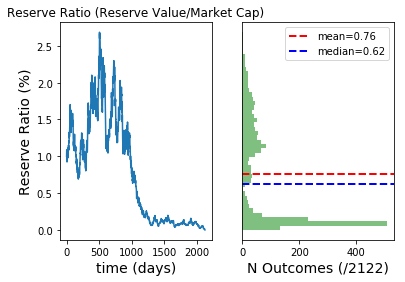

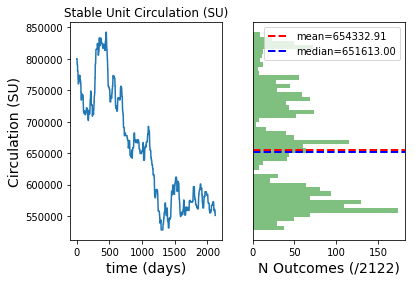

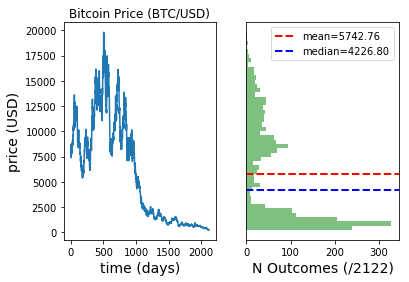

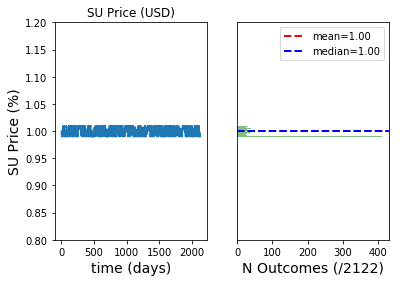

In [49]:
"""
     Run contract simulations to produce a set of random trials. 
"""

# Simulation Paramters.
FLAGS_total_trials = 1
FLAGS_total_steps = 1000000
FLAGS_print_step = False

FLAGS_delta_t = 1.0 # One day to match dataset.
FLAGS_btc_price_drift = 0.0
FLAGS_btc_price_volatility = btc_price_volatility
FLAGS_su_price_drift = 0.0
FLAGS_su_price_volatility = su_price_volatility

FLAGS_initial_reserve_ratio = 1.0
FLAGS_initial_btc_reserve = 100
FLAGS_initial_btc_price = 8000

FLAGS_lowest_ask = 1.01
FLAGS_highest_bid = 0.99

params = Params()
print ("Run experiment with params... \n" + params.__str__())
results = run_experiment(params)
print ("Done.")

print ("Plotting results...")
plot_reserve_ratio(results)
plot_circulation(results)
plot_bitcoin_price(results)
plot_su_price(results)

      Run a multiple trials using the volatility parameters derived from the previous step 

Run experiment with params... 
 total steps: 10000.00
 total trials: 1000.00
 delta t: 1.0000
 btc price drift: 0.0000
 btc price volatility: 0.0391
 su price drift: 0.0000
 su price volatility: 0.0062
 initial reserve ratio: 1.0000
 initial btc reserve: 100.0000
 initial btc price: 8000.0000
 lowest ask: 1.010
 highest bid: 0.990
 print step: False
Done.
Plotting results...


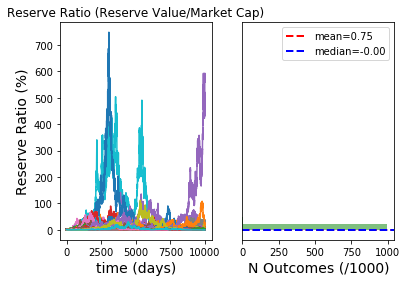

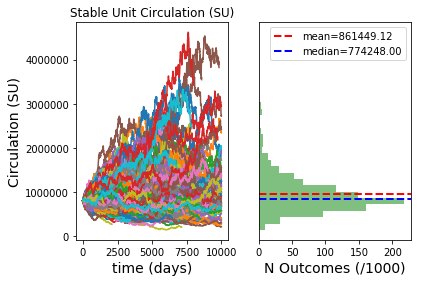

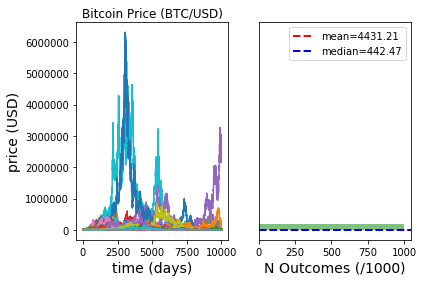

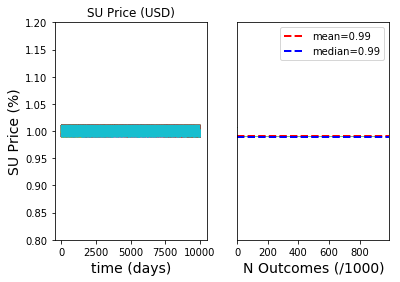

In [51]:
"""
     Run contract simulations to produce a set of random trials. 
"""

# Simulation Paramters.
FLAGS_total_trials = 1000
FLAGS_total_steps = 10000
FLAGS_print_step = False

FLAGS_delta_t = 1.0 # One day to match dataset.
FLAGS_btc_price_drift = 0.0
FLAGS_btc_price_volatility = btc_price_volatility
FLAGS_su_price_drift = 0.0
FLAGS_su_price_volatility = su_price_volatility

FLAGS_initial_reserve_ratio = 1.0
FLAGS_initial_btc_reserve = 100
FLAGS_initial_btc_price = 8000

FLAGS_lowest_ask = 1.01
FLAGS_highest_bid = 0.99

params = Params()
print ("Run experiment with params... \n" + params.__str__())
results = run_experiment(params)
print ("Done.")

print ("Plotting results...")
plot_reserve_ratio(results)
plot_circulation(results)
plot_bitcoin_price(results)
plot_su_price(results)

    Functions for computing the cumulative probability of the reserve dropping bellow a threshold.

In [61]:
"""
     The reserve risk is the likelyhood that the contract's reserve ratio drops bellow a specified bound.
"""

def plot_reserve_risk(results):
    """ Plots the estimate risk that the reserve will be depleted at each lower bound.
        Args:
            results (list(Class)): List of state objects from each trial.
    """
    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.title('Reserve Risk')
    plt.xlabel('time (days)', fontsize=14)
    plt.ylabel('Cumulative (Pr)', fontsize=14)
    for bound in np.linspace(0.0, 1.0, 10):
        rr_at_bound = reserve_risk_at_bound(results, bound)
        plt.plot(rr_at_bound, label='Bound:' + "%.2f" % bound + '   Risk:' + "%.2f" % rr_at_bound[-1])
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
def plot_success_likelihood(results):
    """ Plots the estimate success likelihood that the reserve will be increase above each upper bound.
        Args:
            results (list(Class)): List of state objects from each trial.
    """
    fig = plt.figure()
    ax = plt.subplot(111)
    
    plt.title('Dividend likelihood')
    plt.xlabel('time (days)', fontsize=14)
    plt.ylabel('Cumulative (Pr)', fontsize=14)
    for bound in np.linspace(1.0, 10.0, 10):
        rr_at_bound = success_likelihood_at_bound(results, bound)
        plt.plot(rr_at_bound, label='Bound:' + "%.2f" % bound + '   Risk:' + "%.2f" % rr_at_bound[-1])
        
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


def success_likelihood_at_bound(results, bound):
    """ Calculates the percentage of trials where the contract reserve ratio jumps above the bound.
        Args:
            results (list(Class)): List of state objects from each trial.
            bound (float): The reserve lower bound.
        Returns:
            cumulative_risk (list(float)): The percentage of trials who have passed the lower bound 
                starting from t0 -> tn.
    """
    cumulative_failed = [0]*len(results)
    remaining = range(len(results))
    for step_idx in range(len(results)):
        next_remaining = []
        for idx in remaining:
            if results[idx].steps[-1] >= step_idx and results[idx].reserve_ratio[step_idx] > bound:
                cumulative_failed[step_idx] += 1
            else:
                next_remaining.append(idx)
        remaining = next_remaining
        

    for idx in range(1, len(results)):
        cumulative_failed[idx] += cumulative_failed[idx-1]
    for idx in range(1, len(results)):
        cumulative_failed[idx] /= len(results)
    return cumulative_failed

def reserve_risk_at_bound(results, bound):
    """ Calculates the percentage of trials where the contract reserve ratio drops bellow the bound.
        Args:
            results (list(Class)): List of state objects from each trial.
            bound (float): The reserve lower bound.
        Returns:
            cumulative_risk (list(float)): The percentage of trials who have passed the lower bound 
                starting from t0 -> tn.
    """
    cumulative_failed = [0]*len(results)
    remaining = range(len(results))
    for step_idx in range(len(results)):
        next_remaining = []
        for idx in remaining:
            if results[idx].steps[-1] >= step_idx and results[idx].reserve_ratio[step_idx] < bound:
                cumulative_failed[step_idx] += 1
            else:
                next_remaining.append(idx)
        remaining = next_remaining
        

    for idx in range(1, len(results)):
        cumulative_failed[idx] += cumulative_failed[idx-1]
    for idx in range(1, len(results)):
        cumulative_failed[idx] /= len(results)
    return cumulative_failed

    We calculate the cumulative reserve risk at different lower bounds. (i.e the probability that the reserve ratio will drop below a bound within 3  years time)
    

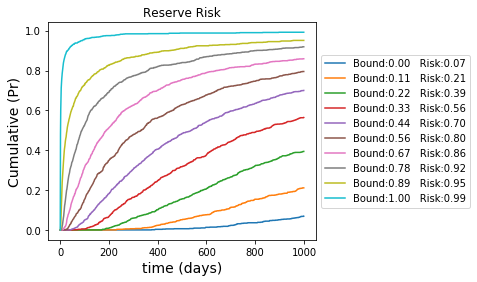

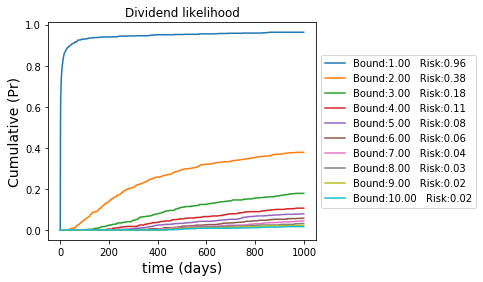

In [62]:
len(results)
plot_reserve_risk(results)
plot_success_likelihood(results)

    Conclusion: Using the above simplified contract and by deriving best effort estimations for the price drift and volatility parameters for Bitcoin and tether using historical prices, we estimate risk bounds for the contract reserve. These cumulative probabilities at different bounds reflect the liklihood that the contract reaches this state within 3 years time. We see that the likelihood of the contract dropping bellow a 10 percent bound is 22%. 

Below: Other experiments.

In [142]:
# Simulation Paramters.
FLAGS_total_trials = 200
FLAGS_total_steps = 1000

bound = 0.8
risk_by_spread = []
for spread in np.linspace(0.0, 0.5, 20):
    FLAGS_lowest_ask = 1.0 + spread
    FLAGS_highest_bid = 1.0 - spread
    params = Params()
    
    mc_states = run_experiment(params)
    
    risk_estimate = reserve_risk_at_bound(mc_states, bound)[-1]
    risk_by_spread.append((spread, risk_estimate))
    

In [143]:
def plot_reserve_risk_by_spread(risk_by_spread, bound):
    fig = plt.figure()
    ax = plt.subplot(111)
    spread, risk = zip(*risk_by_spread)
    
    plt.title('Reserve Risk by spread, at bound = ' + str(bound))
    plt.xlabel('spread (USD)', fontsize=14)
    plt.ylabel('Risk to reserve (Pr)', fontsize=14)
    plt.plot(spread, risk)
    plt.show()

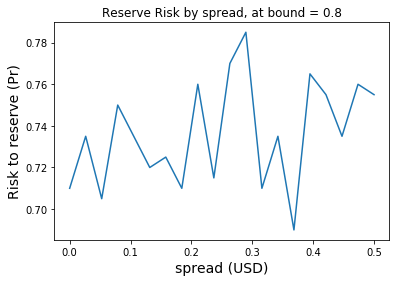

In [144]:
plot_reserve_risk_by_spread(risk_by_spread, 0.8)

In [165]:
!jupyter nbconvert main-jupyter.ipynb --to html

[NbConvertApp] Converting notebook main-jupyter.ipynb to html
[NbConvertApp] Writing 714965 bytes to main-jupyter.html
